In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebraa
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [3]:
df

ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]

Lets start from some exploratory data analysis

In [4]:
total_images = df['ImageId'].nunique()
print(f'Total number of unique images: {total_images}')

Total number of unique images: 192556


There are more raws in the dataset as every ship detection location is in seperate raw and the same image can be in different raws for different ship coordiation masks.

In [5]:
# Number of images with ships
images_with_ships = df.dropna(subset=['EncodedPixels'])['ImageId'].nunique()
print(f'Number of images with ships: {images_with_ships}')

# Number of images without ships
images_without_ships = total_images - images_with_ships
print(f'Number of images without ships: {images_without_ships}')


Number of images with ships: 42556
Number of images without ships: 150000


In [6]:
# Number of ships
num_ships = df['EncodedPixels'].count()
print(f'Total number of ships across all images: {num_ships}')

Total number of ships across all images: 81723


Transforming a RLE code string into a list of pixels of a (768, 768) mask

In [7]:
def rle_to_pixels(rle_code):
    
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

# drop rows with NaN EncodedPixels
ships = df.dropna(subset=['EncodedPixels'])

# add a new column "NumPixels" which will have the count of pixels for each ship
ships['NumPixels'] = ships['EncodedPixels'].apply(lambda x: len(rle_to_pixels(x)))

# calculate the average size of ships
avg_ship_size = ships['NumPixels'].mean()
print(f'Average ship size: {avg_ship_size} pixels')

# calculate the distribution of ship sizes
ship_size_dist = ships['NumPixels'].value_counts().sort_index()
print(f'Ship size distribution: \n{ship_size_dist}')


Average ship size: 1567.4028486472596 pixels
Ship size distribution: 
2        13
4        15
5         5
6         9
7        25
         ..
24214     1
24216     4
24599     2
25245     2
25904     2
Name: NumPixels, Length: 5429, dtype: int64


/tmp/ipykernel_28/3234004489.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships['NumPixels'] = ships['EncodedPixels'].apply(lambda x: len(rle_to_pixels(x)))


Plot histogram for ship sizes

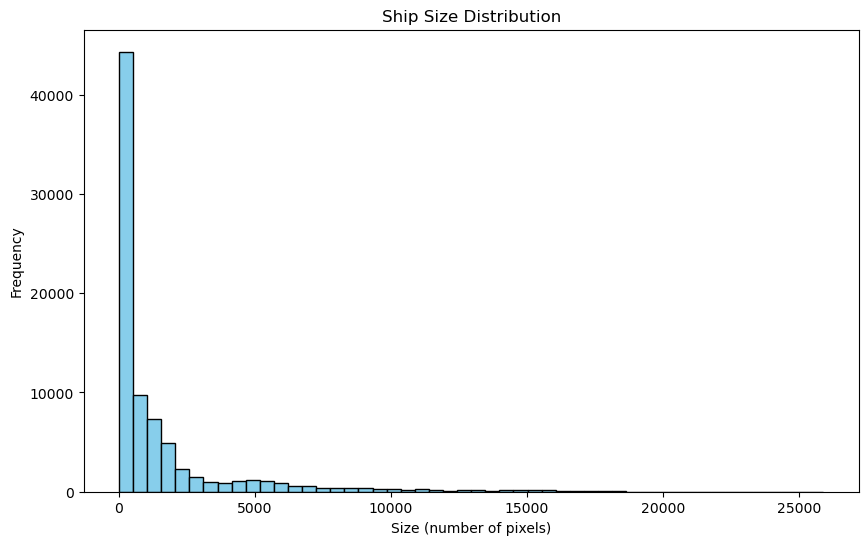

In [8]:
plt.figure(figsize=(10,6))
plt.hist(ships['NumPixels'], bins=50, color='skyblue', edgecolor='black')
plt.title('Ship Size Distribution')
plt.xlabel('Size (number of pixels)')
plt.ylabel('Frequency')
plt.show()

* mask_rle: run-length as string formatted (start length)
* shape: (height, width) of array to return 
* returning numpy array, 1 - mask, 0 - background

In [9]:
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def show_img_with_mask(img_id):
    '''Show image with mask for given image ID.'''
    img_path = f'/kaggle/input/airbus-ship-detection/train_v2/{img_id}'
    img = cv2.imread(img_path)

    img_masks = df.loc[df['ImageId'] == img_id, 'EncodedPixels'].tolist()

    # Create empty mask
    all_masks = np.zeros((768, 768))

    # If ship is present
    if img_masks[0] != img_masks[0]:
        # No ship in this image, just show the image
        plt.imshow(img)
        plt.show()
    else:
        # Ships are present, plot mask on image
        for mask in img_masks:
            all_masks += rle_decode(mask)
        
        fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[0].imshow(img)
        axarr[0].title.set_text('Image')
        axarr[1].imshow(img)
        axarr[1].imshow(all_masks, alpha=0.4, cmap='Reds')
        axarr[1].title.set_text('Image with mask')

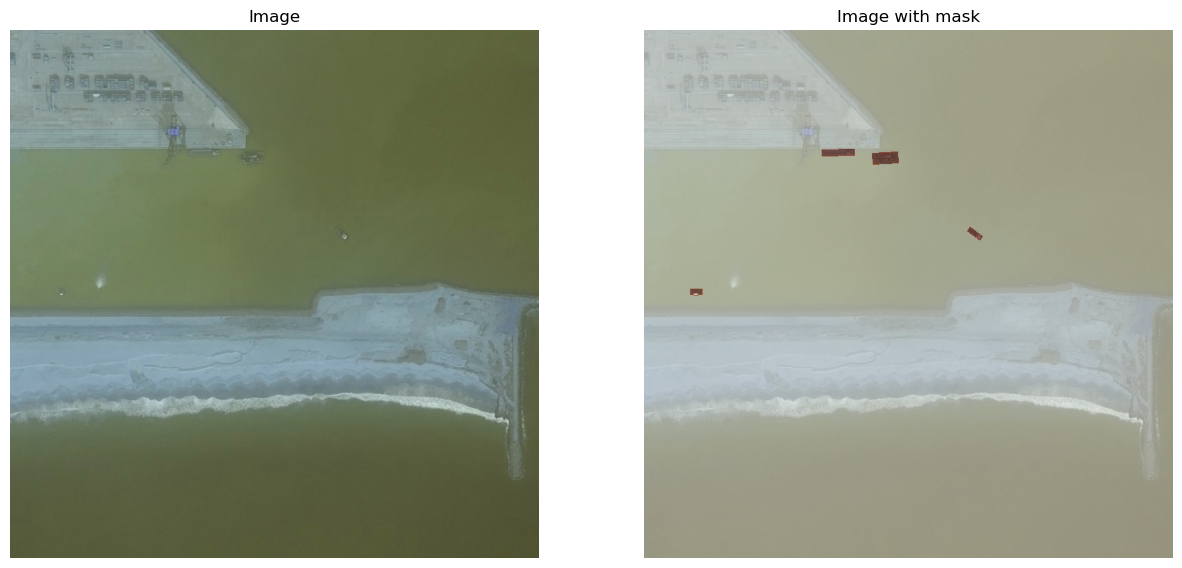

In [10]:
show_img_with_mask('000194a2d.jpg')

I created a visualization of the original image and the converted ship mask.

Splitting the dataset into training and validation 
But before lets take some part of the data

In [11]:
# df = df.sample(n=10000, random_state=42)
df = df[:5000]

In [12]:
df

ImageId                                      EncodedPixels
0     00003e153.jpg                                                NaN
1     0001124c7.jpg                                                NaN
2     000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3     000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4     000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...             ...                                                ...
4995  0575ef4a9.jpg                                                NaN
4996  05760ed17.jpg                                                NaN
4997  05761391c.jpg                                                NaN
4998  0577460a5.jpg                                                NaN
4999  05774940f.jpg                                                NaN

[5000 rows x 2 columns]

In [13]:
from sklearn.model_selection import train_test_split

ships_df = df[df['EncodedPixels'].notnull()]

no_ships_df = df[df['EncodedPixels'].isnull()]

train_ships_df, valid_ships_df = train_test_split(ships_df, test_size=0.2, random_state=42)
train_no_ships_df, valid_no_ships_df = train_test_split(no_ships_df, test_size=0.2, random_state=42)

train_df = pd.concat([train_ships_df, train_no_ships_df])
valid_df = pd.concat([valid_ships_df, valid_no_ships_df])


In [14]:

from tensorflow.keras.preprocessing.image import img_to_array

from keras.utils import to_categorical

border = 5
im_chan = 3
n_classes = 2 

def preprocess_data(img_ids, img_dir, df, train=True):
    """This function preprocesses the image and mask data"""
    X = np.zeros((len(img_ids), 256, 256, im_chan), dtype=np.uint8)  # changed dimensions here
    y = np.zeros((len(img_ids), 256, 256, n_classes), dtype=np.uint8)  # changed dimensions here
    for n, id_ in enumerate(img_ids):
        
        img_path = img_dir + id_
        img = cv2.imread(img_path)
        
#         if img is not None:
#             print(f"Image {id_} loaded successfully.")
#         else:
#             print(f"Failed to load image {id_}.")
        img = cv2.resize(img, (256, 256))  
#         print(f"Resized image shape: {img.shape}")  # Print the dimensions of the resized image
        X[n] = img

        if train:

            mask = np.zeros((768, 768))
            masks = df.loc[df['ImageId'] == id_, 'EncodedPixels'].tolist()


            if masks[0] != masks[0]:

                pass
            else:
                for mask_ in masks:
                    mask += rle_decode(mask_)
            

            mask = cv2.resize(mask, (256, 256))  # added resizing here
#             print(f"Resized mask shape: {mask.shape}") 

            mask = np.expand_dims(mask, axis=-1)
#             print(f"Expanded mask shape: {mask.shape}") 
            mask_cat = to_categorical(mask, num_classes=n_classes)
    
#             print(f"Categorical mask shape: {mask_cat.shape}")
            y[n, ...] = mask_cat.squeeze()

    return X, y


img_dir = '/kaggle/input/airbus-ship-detection/train_v2/'


train_ids = train_df['ImageId'].values
valid_ids = valid_df['ImageId'].values


import os

if os.path.exists('X_train.npy') and os.path.exists('y_train.npy'):

    print("Loading data...")
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')
else:

    print("Preprocessing data...")
    X_train, y_train = preprocess_data(train_ids, img_dir, train_df)


    print("Saving data...")
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)


if os.path.exists('X_valid.npy') and os.path.exists('y_valid.npy'):
    print("Loading data...")
    X_valid = np.load('X_valid.npy')
    y_valid = np.load('y_valid.npy')
else:
    print("Preprocessing data...")
    X_valid, y_valid = preprocess_data(valid_ids, img_dir, valid_df)

    print("Saving data...")
    np.save('X_valid.npy', X_valid)
    np.save('y_valid.npy', y_valid)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Preprocessing data...
Saving data...
Preprocessing data...
Saving data...


In [15]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy

def weighted_binary_crossentropy(y_true, y_pred, weight_factor):
    # Convert y_true to float32 data type
    y_true = tf.cast(y_true, tf.float32)
    
    # Compute the binary cross-entropy loss
    binary_loss = binary_crossentropy(y_true, y_pred)
    
    # Apply the weight factor to the ship class predictions
    weighted_loss = y_true[..., 1] * weight_factor * binary_loss
    
    return weighted_loss



In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the U-Net
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Final layer
    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)

    return model


In [17]:
from keras import backend as K
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [18]:
total_ship_pixels = np.sum(y_train[:, :, :, 1])
total_background_pixels = np.sum(y_train[:, :, :, 0])

class_weight = {0: 1.0, 1: total_background_pixels / total_ship_pixels}

print("Class Weights:")
print(class_weight)


Class Weights:
{0: 1.0, 1: 492.2563882986432}


In [19]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

In [20]:
from tensorflow.keras.optimizers import Adadelta

input_shape = (256, 256, 3)
n_classes = 2  # number of classes (background and ship in your case)

model = build_unet(input_shape, n_classes)


# opt = Adadelta(learning_rate=0.01, rho=0.95)

# adadelta optimizer rho = 0.95 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

# model.compile(optimizer='adam', loss=focal_loss, metrics=[iou_coef])

# model.compile(optimizer='adam', loss=dice_loss, metrics=[iou_coef])

ship_weight = 1000

# model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, ship_weight),  metrics=[iou_coef])




In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001),
    ModelCheckpoint('model_best_checkpoint.h5', verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=16,
                    epochs=20,
                    callbacks=callbacks)



Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.0185 - dice_coef: 0.9974
Epoch 1: val_loss improved from inf to 0.00815, saving model to model_best_checkpoint.h5
250/250 [==============================] - 224s 776ms/step - loss: 0.0185 - dice_coef: 0.9974 - val_loss: 0.0081 - val_dice_coef: 0.9984
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.0145 - dice_coef: 0.9976
Epoch 2: val_loss did not improve from 0.00815
250/250 [==============================] - 176s 705ms/step - loss: 0.0145 - dice_coef: 0.9976 - val_loss: 0.0106 - val_dice_coef: 0.9985
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.0119 - dice_coef: 0.9978
Epoch 3: val_loss did not improve from 0.00815
250/250 [==============================] - 176s 704ms/step - loss: 0.0119 - dice_coef: 0.9978 - val_loss: 0.0094 - val_dice_coef: 0.9983
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.0100 - dice_coef: 0.9978
Epoch 4: val_loss 

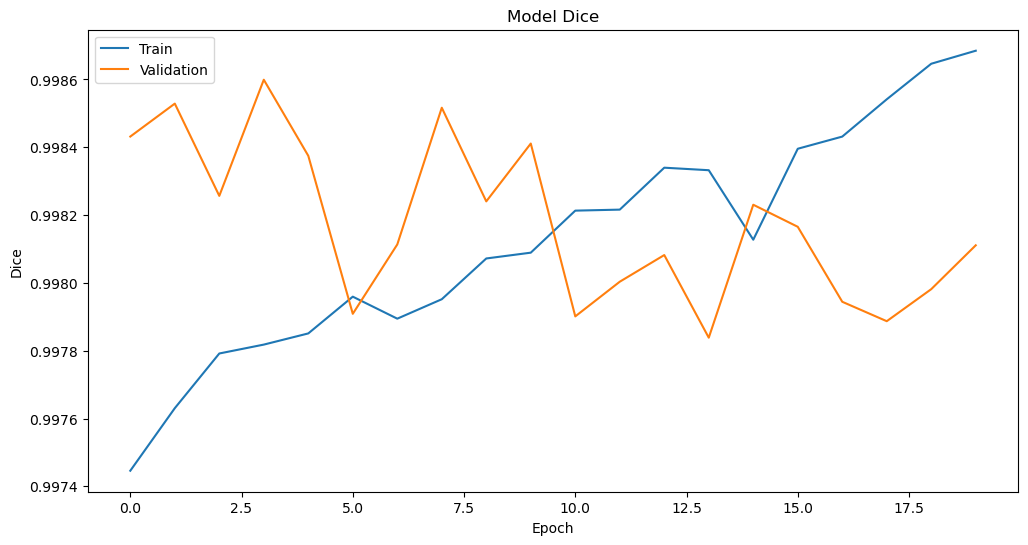

In [23]:
# Plot IoU over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice')
plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 22ms/step


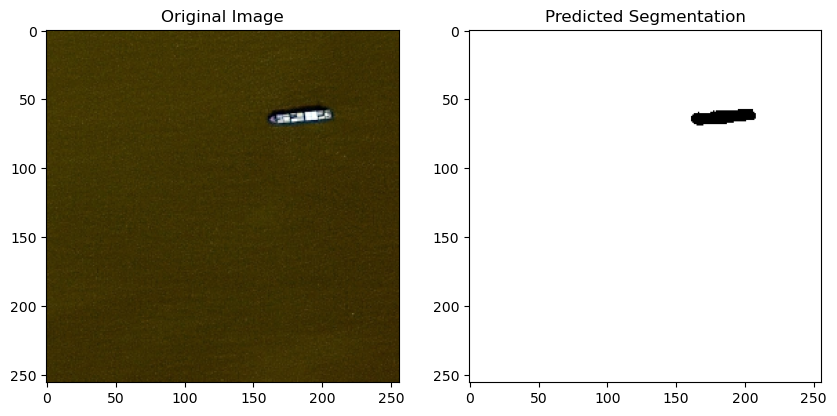

In [32]:
def preprocess_test_data(img_ids, img_dir):
    """This function preprocesses the image data"""
    X = np.zeros((len(img_ids), 256, 256, im_chan), dtype=np.uint8)

    for n, id_ in enumerate(img_ids):
        img_path = os.path.join(img_dir, id_)  # use os.path.join for safer path construction
        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue

        img = cv2.resize(img, (256, 256))  
        X[n] = img

    return X



img_dir = '/kaggle/input/airbus-ship-detection/test_v2/'

test_ids = ['00c3db267.jpg'] 

X_test = preprocess_test_data(test_ids, img_dir)

predicted_segmentation = model.predict(X_test)

predicted_segmentation = (predicted_segmentation > 0.9).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray')  
plt.title('Predicted Segmentation')
plt.show()


1/1 [==============================] - 0s 20ms/step


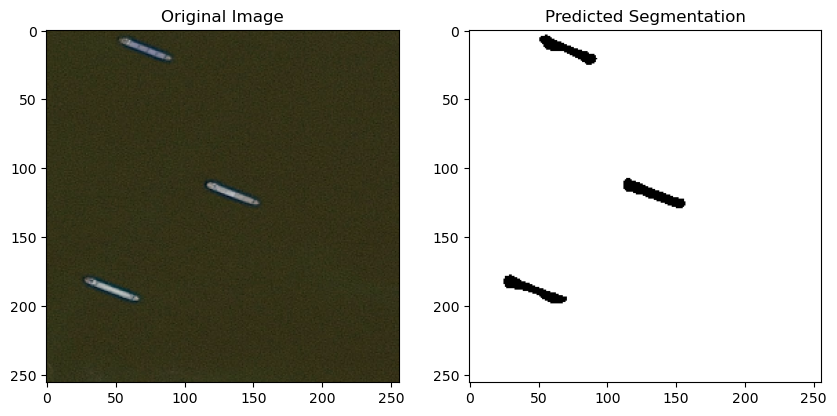

In [33]:
test_ids = ['00dc34840.jpg']  

X_test = preprocess_test_data(test_ids, img_dir)

predicted_segmentation = model.predict(X_test)

predicted_segmentation = (predicted_segmentation > 0.9).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray') 
plt.title('Predicted Segmentation')
plt.show()


1/1 [==============================] - 0s 28ms/step


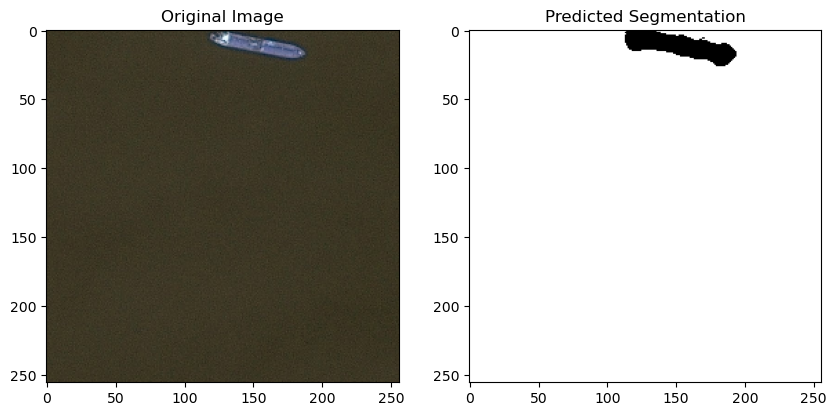

1/1 [==============================] - 0s 19ms/step


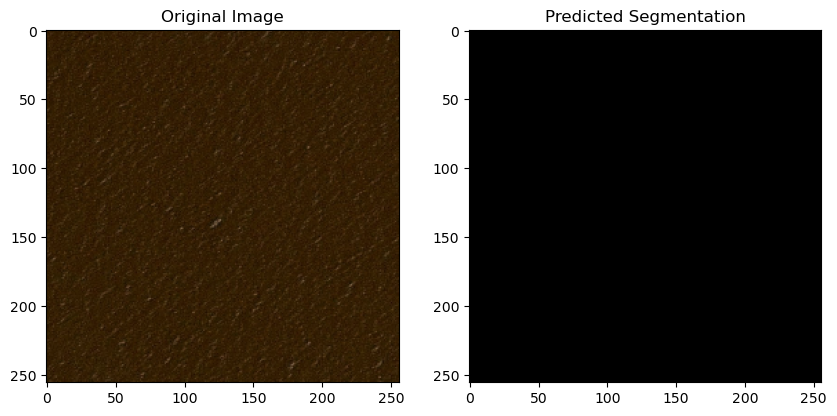

1/1 [==============================] - 0s 20ms/step


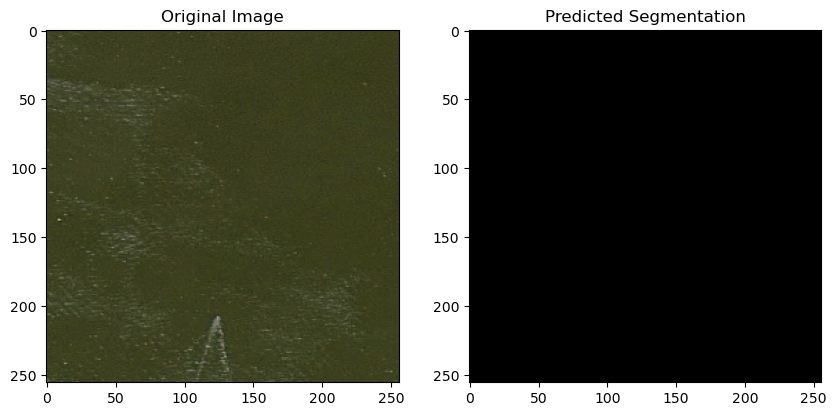

1/1 [==============================] - 0s 19ms/step


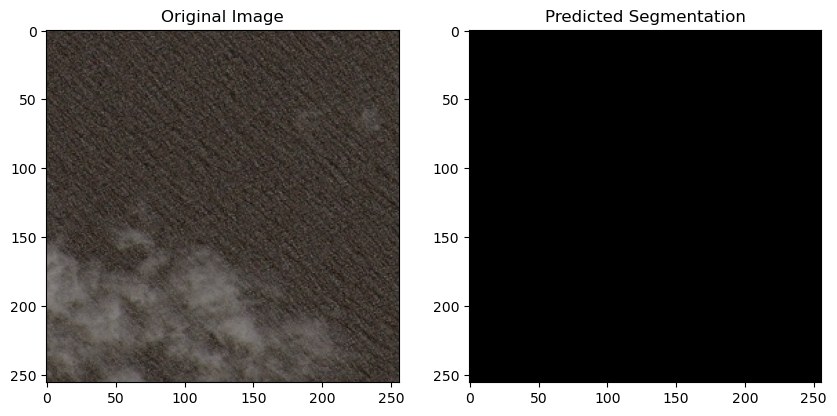

1/1 [==============================] - 0s 20ms/step


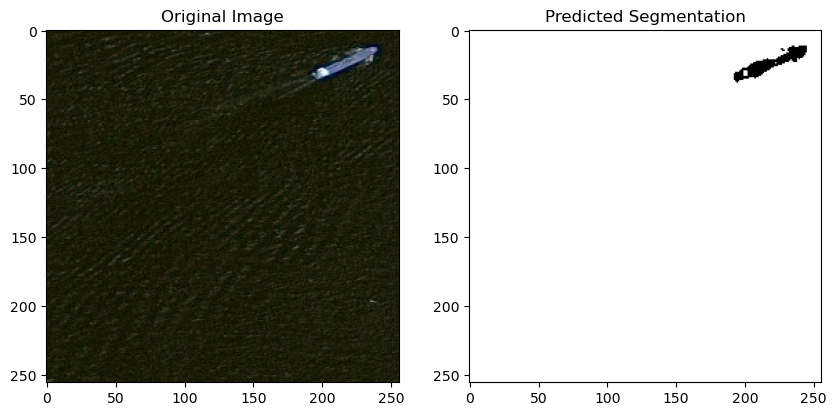

1/1 [==============================] - 0s 20ms/step


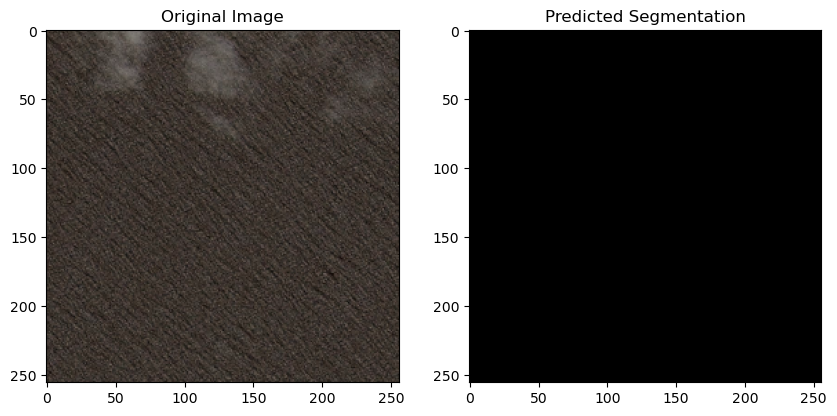

1/1 [==============================] - 0s 20ms/step


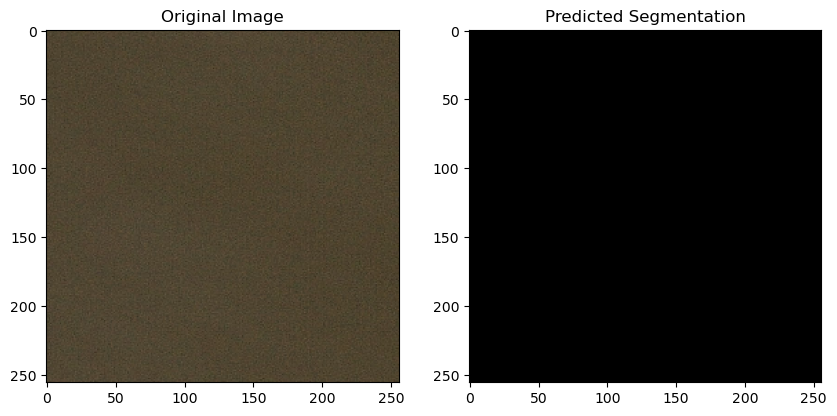

1/1 [==============================] - 0s 20ms/step


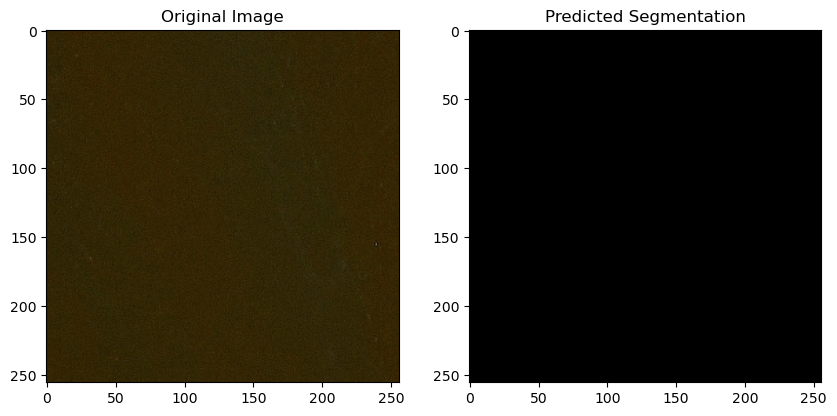

1/1 [==============================] - 0s 19ms/step


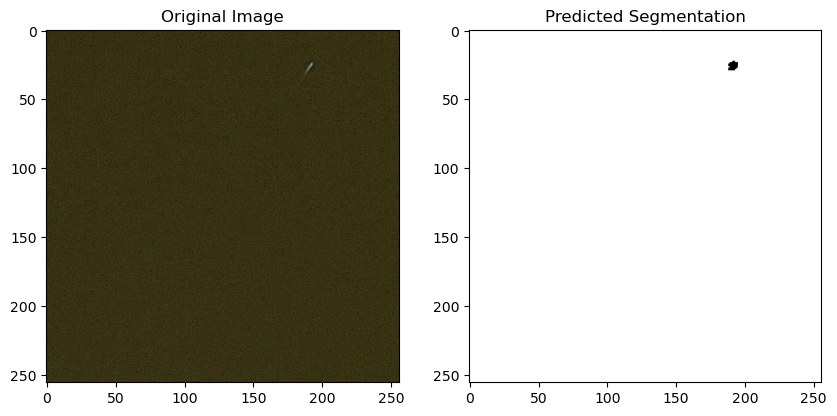

1/1 [==============================] - 0s 22ms/step


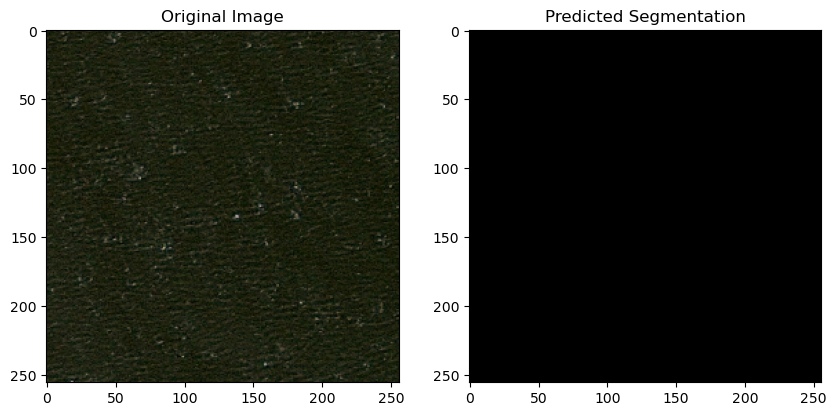

1/1 [==============================] - 0s 20ms/step


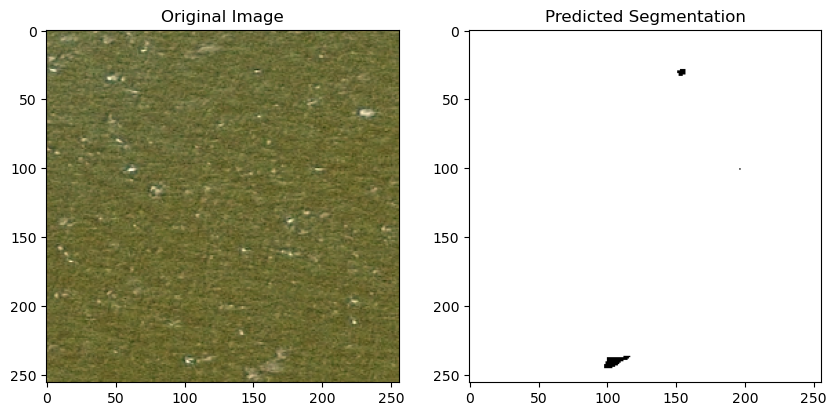

1/1 [==============================] - 0s 21ms/step


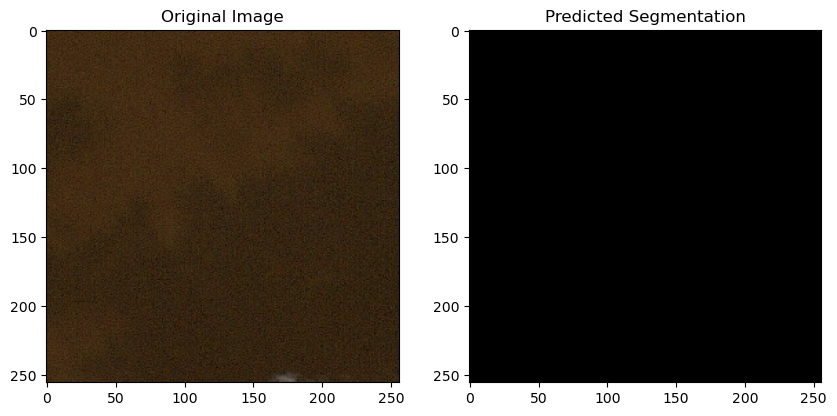

1/1 [==============================] - 0s 21ms/step


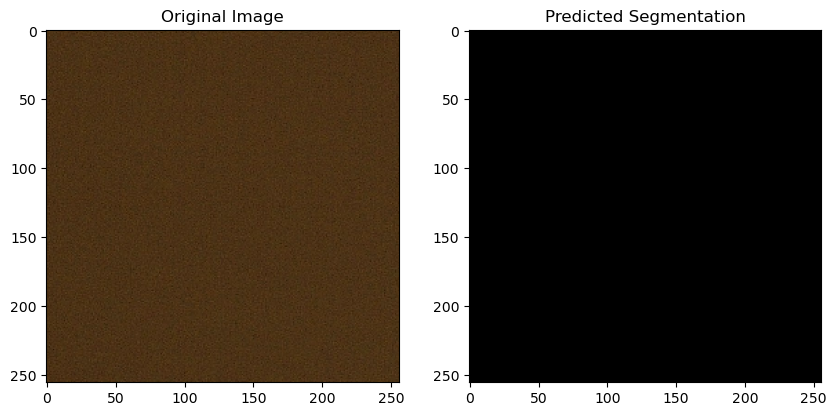

1/1 [==============================] - 0s 20ms/step


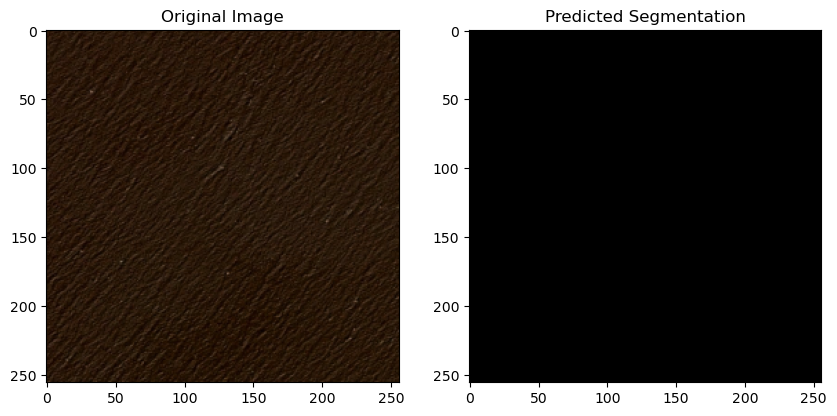

1/1 [==============================] - 0s 20ms/step


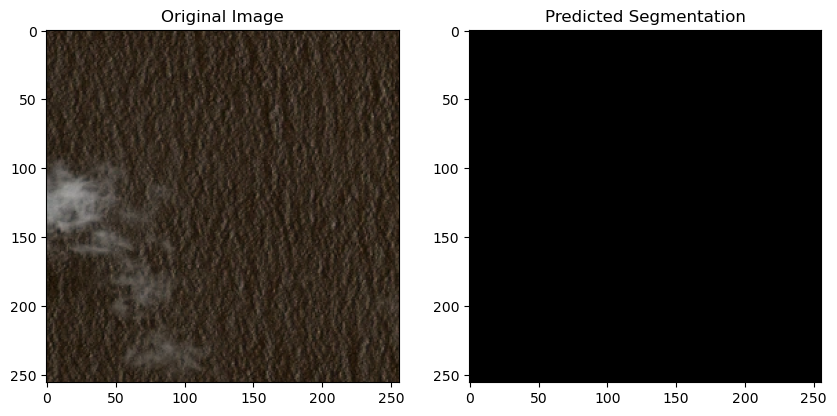

1/1 [==============================] - 0s 20ms/step


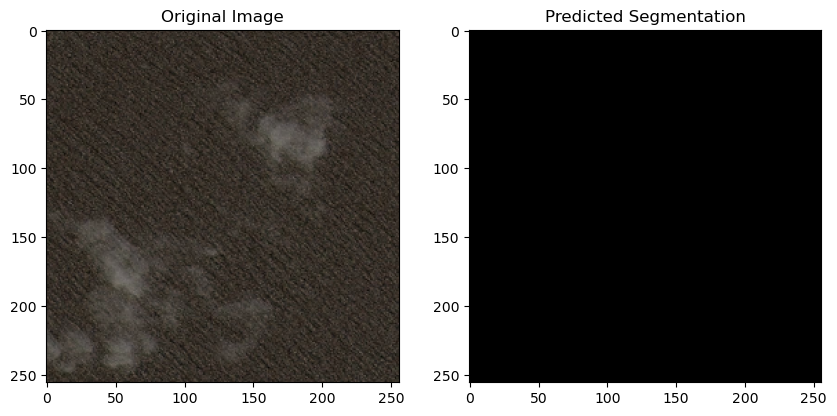

1/1 [==============================] - 0s 20ms/step


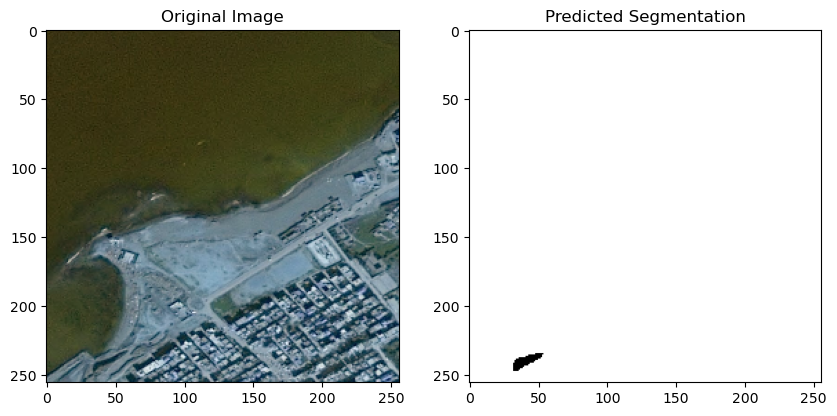

1/1 [==============================] - 0s 20ms/step


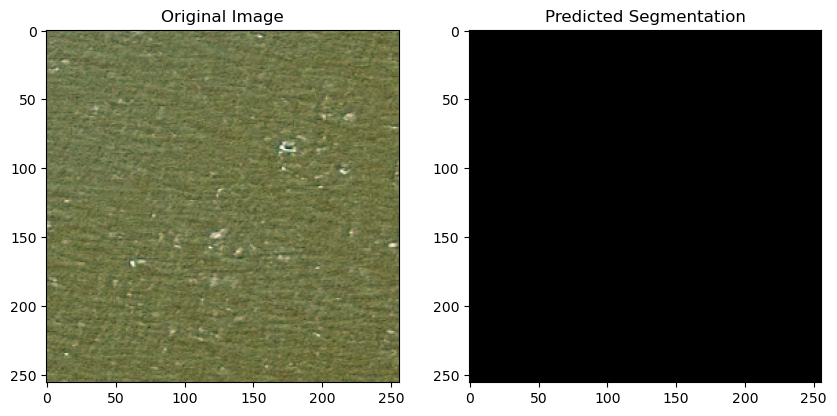

1/1 [==============================] - 0s 19ms/step


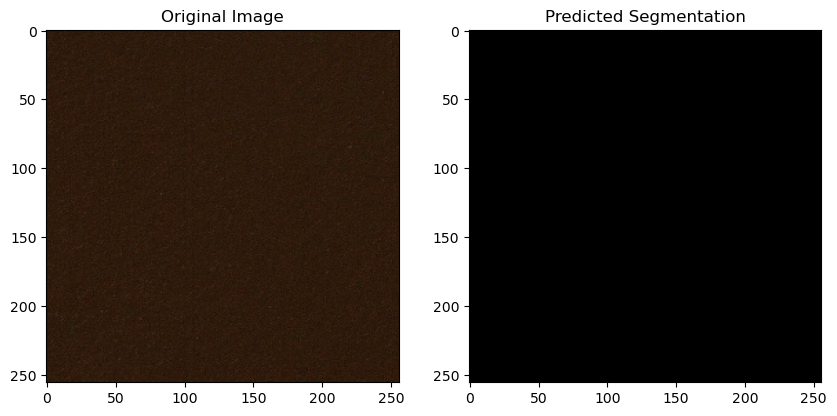

1/1 [==============================] - 0s 19ms/step


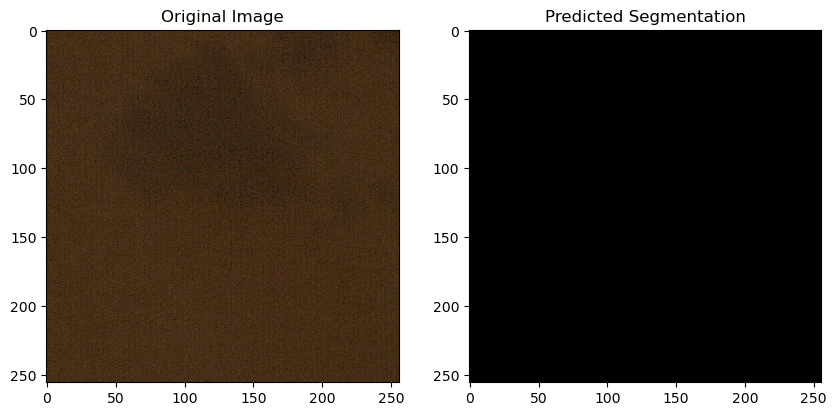

In [34]:
import random
import os
import matplotlib.pyplot as plt

# Assuming you have a function preprocess_test_data to preprocess test data

# Define the path to your test images directory
test_img_dir = '/kaggle/input/airbus-ship-detection/test_v2/'

# Get the list of image names in the test directory
test_ids = os.listdir(test_img_dir)

# Select 20 random image names from the test dataset
random_test_img_names = random.sample(test_ids, k=20)

# Loop through the selected random image names
for img_name in random_test_img_names:
    # Preprocess the image
    img_path = os.path.join(test_img_dir, img_name)
    X_test = preprocess_test_data([img_path], test_img_dir)

    # Make predictions on the test image
    predicted_segmentation = model.predict(X_test)

    # Apply threshold to convert probabilities to binary predictions
    predicted_segmentation = (predicted_segmentation > 0.9).astype(np.uint8)

    # Plot original image and predicted mask
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[0])
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray')  
    plt.title('Predicted Segmentation')
    plt.show()


In [27]:
import PIL

In [28]:
PIL.Image.open('/kaggle/input/airbus-ship-detection/test_v2/00dc34840.jpg').size

(768, 768)